In [16]:
import sys
import glob
sys. path.append("../src")
import clean_data
import read_outputs
import json
import numpy as np
import NNimaker
import pandas as pd
import ann_model as ann
from collections.abc import MutableMapping
from ase.data import atomic_numbers
from matplotlib import pyplot as plt
import seaborn as sns
#_____________________for LR and KRR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#___________related to warning about mean_squared_error in old and new versions
try:
    from sklearn.metrics import root_mean_squared_error
    def rmse(y_true, y_pred):
        return root_mean_squared_error(y_true, y_pred)
except ImportError:
    def rmse(y_true, y_pred):
        return mean_squared_error(y_true, y_pred, squared=False)
        
from sklearn.linear_model import Lasso
#____________________for Random forest Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import GPy
import itertools
import joblib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating JSON files as raw data. 
Extracting raw data is the priliminary step, it is done with NNimaker package

In [6]:
folders = ['nickel', 'perovskite', 'quartz', 'water', 'ausurf']
folders2 = ['mc3d', 'mote2_bulk', 'wte2_bulk']

data_leo = []
#NNimaker out of date, it does not have the detector of " Smooth grid is missing or identical to Dense grid" But it works for the "folders" cases well!
#for f in folders:
#    data_leo.extend(NNimaker.create_json(folder=f"../data-leo/{f}/outputs/", outname= f"../data-leo/{f}/data.json", platform='Leonardo-booster', algoname='davidson'))

for f in folders:
    data_leo.extend(read_outputs.create_json(folder=f"../data-leo/{f}/outputs/", outname= f"../data-leo/{f}/data.json", platform='Leonardo-booster', algoname='davidson'))

#from module read_outputs.py!
for f2 in folders2:
    data_leo.extend(read_outputs.create_json(folder=f"../data-leo/{f2}/", outname= f"../data-leo/{f2}/data.json", platform='Leonardo-booster', algoname='davidson'))

with open("../data-leo/data-leo-tot.json", 'w') as fw:
    json.dump(data_leo, fw, indent=2)

Data successfully saved to ../data-leo/nickel/data.json
Data successfully saved to ../data-leo/perovskite/data.json
Data successfully saved to ../data-leo/quartz/data.json
Data successfully saved to ../data-leo/water/data.json
Data successfully saved to ../data-leo/ausurf/data.json
Skipping file ../data-leo/mc3d/aiida_160093.out: Smooth grid is missing or identical to Dense grid.
Skipping file ../data-leo/mc3d/aiida_83532.out: Smooth grid is missing or identical to Dense grid.
Skipping file ../data-leo/mc3d/aiida_144362.out: Smooth grid is missing or identical to Dense grid.
Skipping file ../data-leo/mc3d/aiida_75071.out: Smooth grid is missing or identical to Dense grid.
Skipping file ../data-leo/mc3d/aiida_101092.out: Smooth grid is missing or identical to Dense grid.
Skipping file ../data-leo/mc3d/aiida_149145.out: Smooth grid is missing or identical to Dense grid.
Skipping file ../data-leo/mc3d/aiida_89092.out: Smooth grid is missing or identical to Dense grid.
Skipping file ../dat

# Preprocessing Data
Some preparation is needed after loading data in a JSON file. This could significantly enhance the usability and quality of the data for machine learning or other analyses.
The steps of preprocessing are: 

### 1. Flatten and Transform JSON Data:
+ The flatten_dict function is used to flatten nested dictionaries into a single level. This simplifies working with JSON data and makes it easier to convert to a DataFrame.
    
### 2. Feature Engineering:
+ Functions like compute_nbetas and count_lanth_trans generate derived features, such as:
   * The number of beta elements (n_betas).
   * Counts of lanthanides and transition metals.
    
### 3. Data Cleaning:
+ Removes or handles missing, invalid, or extreme values (e.g., dropping rows where smoothgrid is invalid or timer values are outside a reasonable range in clean_chemistry_data).
    
### 4. Normalization and Computational Metrics:
+ Calculates normalized features like normalized_time_per_call to ensure consistent scaling and remove biases. Adds derived metrics such as computational_complexity, `n_el^3`, and `time_per_call`.

### 5. Data Integration:
+ Processes multiple datasets (e.g., marconi, marconi_100, chemistry, leonardo-booster) into a unified format with consistent columns.
Final Output:

**Combines all data into a consolidated DataFrame and saves it to a file (all_data.xz) for further use.**


In [18]:
####____Important note _____________________________________________________________
####____This cell is not mandatory, the functions are saved in module clead_data.py!
elements = list(atomic_numbers.keys())

#1. Flatten and Transform JSON Data

def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, MutableMapping):  # Use collections.abc.MutableMapping
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            if type(v) == list:
                if type(v[1]) == str:
                    items.append((new_key, v[0]))
                    items.append((new_key + "_unit", v[1]))
                else:
                    for it, v_ in enumerate(v):
                        items.append((new_key + f"_{it}", v_))

            else:
                items.append((new_key, v))
    return dict(items)
    
#2. compute useful parameters:  Feature Engineering 

def compute_nbetas(NL, NBETA, NATOMSTYPE):
    nl = np.array(NL.split('|')[1::2], dtype='int')
    betas_per_elements = np.array(NBETA.split('|')[1::2], dtype='int')
    natom_per_element = np.array(NATOMSTYPE.split('|')[3::4], dtype=float)
    nelements = len(betas_per_elements)
    natoms_list = [np.repeat(natom_per_element[i], betas_per_elements[i])
                   for i in range(nelements)]
    natoms_list = np.array(
        [item for sublist in natoms_list for item in sublist])
    try:
        tot_betas = np.sum(2*nl+1 * natoms_list)
    except:
        return np.sum(2*nl+1 * natom_per_element[0])
    return tot_betas

def count_lanth_trans(data):
    lanthanid = np.zeros(len(data))
    transition = np.zeros(len(data))

    lanthanids = ['Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu',
                  'Gb', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']
    first_row_transition_metals = ['V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni']

    for el in lanthanids:
        lanthanid += [int(el in line.split('|')[1::4])
                      for line in data['NatomsType']]
    lanthanid = np.array(lanthanid)  # .astype('bool').astype('int')
    for el in first_row_transition_metals:
        transition += [int(el in line.split('|')[1::4])
                       for line in data['NatomsType']]
    transition = np.array(transition)  # .astype('bool').astype('int')

    return lanthanid, transition

# 3. Datacleaning

def clean_data(filename):

    # Load JSON data
    with open(filename) as f:
        data = json.load(f)

    cname = 'computational_complexity'
    tname = 'time_per_call'
    norm_tname = 'normalized_time_per_call'

    # Flatten all nested dictionaries
    data = [flatten_dict(d) for d in data]
    df = pd.DataFrame.from_dict(data).drop(0)
    df = df.rename(columns={'dims_Threads': 'threads_per_node'})

    # Calculate derived features
    lanthanid, transition = count_lanth_trans(df)
    df['n_lanthanid'] = lanthanid
    df['n_transition'] = transition
    #print(df[['Nl', 'Nbeta', 'NatomsType']].head())
    df['n_betas'] = [compute_nbetas(nl, nb, na) for nl, nb, na in zip(
        df['Nl'], df['Nbeta'], df['NatomsType'])]
    # The first column is always the target
    columns_to_keep = [norm_tname, 'iter_sum_band', tname, 'n_el',
                       'n_el^3', 'n_species', 'dims_nat', 'n_transition',
                       'n_lanthanid', 'dims_nbands', 'convergence',
                       'smooth_grid_rec', 'dims_nkpoints', 'n_betas',
                       'n_cores', 'n_nodes', 'threads_per_node', 'dims_npool']

    if df['Platform'].values[0] == 'Leonardo-booster':
        corespernode = 32

    # Create a dictionary for columns to keep or calculate
    columns_to_add = {}
    for c in df.columns:
        if len(df[c].unique()) > 1 or c in columns_to_keep:
            try:
                columns_to_add[c] = pd.to_numeric(df[c], errors='coerce')  # Coerce non-numeric to NaN
            except ValueError:
                pass

    # Add calculated features directly to the dictionary
    columns_to_add[tname] = columns_to_add.get('clocks_PWSCF', 0) * (
        1 / columns_to_add.get('iter_sum_band', 1)
    )
    columns_to_add['n_cores'] = columns_to_add.get('threads_per_node', 0) * columns_to_add.get('dims_MPI tasks', 1)
    columns_to_add['n_nodes'] = columns_to_add['n_cores'] // corespernode
    columns_to_add['n_el^3'] = columns_to_add['n_el'] ** 3
    columns_to_add[cname] = columns_to_add['n_el^3'] * columns_to_add['dims_nkpoints'] / columns_to_add['n_cores']
    columns_to_add[norm_tname] = columns_to_add[tname] / columns_to_add[cname]

    # Create a DataFrame from the collected columns
    df_ = pd.DataFrame(columns_to_add)

    # Finalize the DataFrame
    df_tot = df_[columns_to_keep]
    df_tot = df_tot.rename(columns={'iter_sum_band': 'n_calls',
                                    'dims_npool': 'n_pool',
                                    'dims_nkpoints': 'n_k',
                                    'dims_nat': 'n_at',
                                    'dims_nbands': 'n_ks',
                                    'smooth_grid_rec': 'n_g_smooth'})

   # df_tot['arch'] = architecture_id

    # Handle element-specific data
    df_el = pd.DataFrame(index=df_tot.index, columns=elements)
    df_el.loc[df_el.index, elements] = 0  # Initialize all elements to 0
    if 'pseudo' in df.columns:  # Ensure 'pseudo' exists
        df_el[df.pseudo.str.get_dummies().columns] = df.pseudo.str.get_dummies().values

    df_tot = pd.concat([df_tot, df_el], axis=1)
    del df_el, df
    return df_tot


In [19]:
df_leo = clean_data.clean_data("../data-leo/data-leo-tot.json")

#df_leo.to_pickle("../data-leo/all_data.xz")

AttributeError: 'function' object has no attribute 'clean_data'

2025-09-18 10:31:27.887041: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
 /home/mandana/VENV/NNenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning:The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


Epoch 1/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7616 - mae: 0.7513 - val_loss: 0.6152 - val_mae: 0.6050
Epoch 2/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5779 - mae: 0.5677 - val_loss: 0.4469 - val_mae: 0.4367
Epoch 3/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4478 - mae: 0.4376 - val_loss: 0.4635 - val_mae: 0.4532
Epoch 4/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3988 - mae: 0.3885 - val_loss: 0.4313 - val_mae: 0.4209
Epoch 5/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3582 - mae: 0.3478 - val_loss: 0.3462 - val_mae: 0.3358
Epoch 6/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3253 - mae: 0.3148 - val_loss: 0.3820 - val_mae: 0.3715
Epoch 7/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3067 - mae: 0.2962 - val_loss: 0.3613 - val_mae: 0.3508
Epoch 8/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2832 - mae: 0.2726 - val_loss: 0.4088 - val_mae: 0.3982
Epoch 9/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

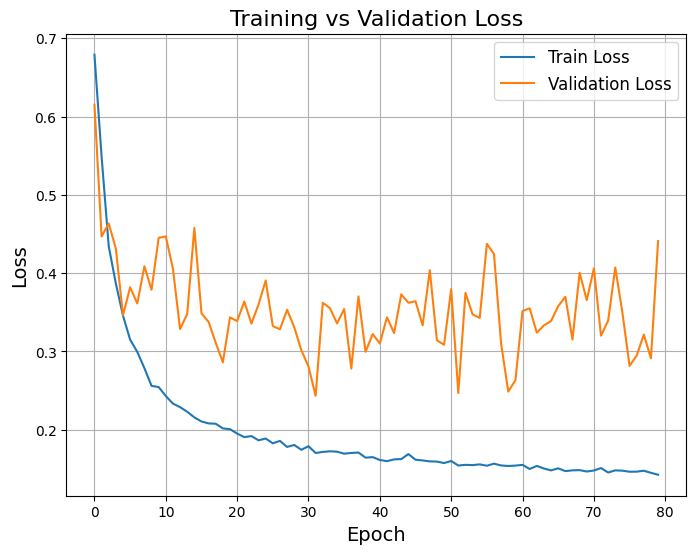

Train Loss (eval mode): 0.4427
Val Loss   (eval mode): 0.4522


In [5]:
dfx = df_leo.drop(columns = ['time_per_call', 'n_calls', 'normalized_time_per_call', 'convergence', 'Al1', 'Cl1', 'Co1', 'Cr1', 'F1', 'H1',
       'H2', 'Ir1', 'La1', 'N1', 'Na1', 'Nb1', 'Ni1', 'O1', 'O2', 'Re1', 'S1',
       'Si1', 'Ti1', 'V1'] + elements).astype('float')
#dfx.columns
dfy = df_leo['normalized_time_per_call'].astype('float')
# dfx.arch = 10
model = ann.TimePerCall(activation='swish', l1=1e-5,
             l2=1e-4, lr=0.0005, loss='mae', nvars = len(dfx.columns))
ind_tr, ind_val = ann.train_test_indices(dfx)
X_tr = dfx.loc[ind_tr]
Y_tr = dfy.loc[ind_tr]
X_val = dfx.loc[ind_val]
Y_val = dfy.loc[ind_val]
model.train_normed(X_tr, Y_tr, epochs=80, validation_split=0.2, plot=1, save_path="training_plot0005_test.png")
# After training, check proper losses:
train_loss, val_loss = model.evaluate_losses(
    model.normalize_x(X_tr), 
    model.normalize_y(Y_tr),
    model.normalize_x(X_val), 
    model.normalize_y(Y_val)
)
model.save("model_leonardo_test.keras")

In [ ]:
# Suppose you did 80/20 split before calling train_normed
#X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

#model= TimePerCall()
#model.train_normed(X_train, Y_train, epochs=100, validation_split=0.2)
ind_tr, ind_val = ann.train_test_indices(dfx)
X_tr = dfx.loc[ind_tr]
Y_tr = dfy.loc[ind_tr]
X_val = dfx.loc[ind_val]
Y_val = dfy.loc[ind_val]

# After training, check proper losses:
train_loss, val_loss = model.evaluate_losses(
    model.normalize_x(X_tr), 
    model.normalize_y(Y_tr),
    model.normalize_x(X_val), 
    model.normalize_y(Y_val)
)

In [ ]:
#df_leo = pd.read_pickle("../data-leo/all_data.xz")

In [ ]:
#%load_ext cudf.pandas

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LR RMS: 8.831679997842694e-06
KRR RMS: 3.9520861397931215e-06
FCNN RMS: 3.849669397263062e-06
RF RMS: 1.5328081244567335e-06
LR MAE: 1.7842183139806812e-06
KRR MAE: 3.6126395038253027e-07
FCNN MAE: 2.7119976506329564e-07
RF MAE: 1.672928046595028e-07
R² values:
Linear Regression: 0.037
Kernel Ridge: 0.807
Random Forest: 0.971
Neural Network: 0.817


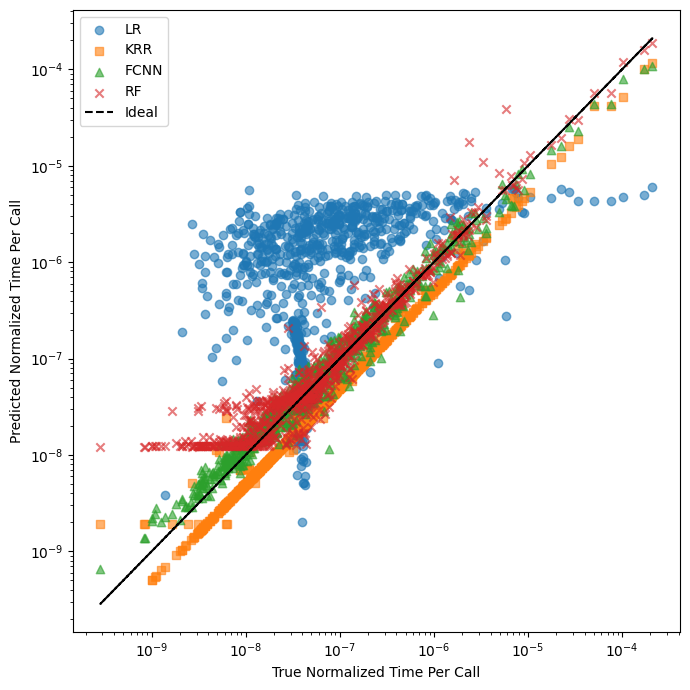

In [6]:
dfx = df_leo.drop(columns = ['time_per_call', 'n_calls', 'normalized_time_per_call', 'convergence', 'Al1', 'Cl1', 'Co1', 'Cr1', 'F1', 'H1',
       'H2', 'Ir1', 'La1', 'N1', 'Na1', 'Nb1', 'Ni1', 'O1', 'O2', 'Re1', 'S1',
       'Si1', 'Ti1', 'V1'] + elements).astype('float')
dfy = df_leo['normalized_time_per_call'].astype('float')

ind_tr, ind_val = ann.train_test_indices(dfx)
X_tr = dfx.loc[ind_tr]
Y_tr = dfy.loc[ind_tr]
X_val = dfx.loc[ind_val]
Y_val = dfy.loc[ind_val]
#print(X_val)
#type(X_val)
test_input_0 = dfx.iloc[[10]]  # Keep double brackets to return a DataFrame
#'n_el', 'n_el^3', 'n_species', 'n_at', 'n_transition', 'n_lanthanid',
  #     'n_ks', 'n_g_smooth', 'n_k', 'n_betas', 'n_cores', 'n_nodes',
  #     'threads_per_node', 'n_pool'
Y_hat = model.predict_normed(X_val)


# Prepare your features and target
X = X_val.values  # 15 features
y = Y_val.values  # or normalized

# Linear Regression
lr = LinearRegression()
lr.fit(X, y)
y_pred_lr = lr.predict(X)

# Kernel Ridge Regression
krr = KernelRidge(kernel='rbf', alpha=1.0)
krr.fit(X, y)
y_pred_krr = krr.predict(X)

# Initialize Random Forest
rf = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    max_depth=None,        # Let trees grow fully
    random_state=42,       # For reproducibility
    n_jobs=-1              # Use all CPUs
)

# Fit model
rf.fit(X, y)
y_pred_rf = rf.predict(X)

# Metrics

print("LR RMS:", rmse(y, y_pred_lr))
print("KRR RMS:", rmse(y, y_pred_krr))
print("FCNN RMS:", rmse(y, Y_hat))
print("RF RMS:", rmse(y, y_pred_rf))
print("LR MAE:", mean_absolute_error(y, y_pred_lr))
print("KRR MAE:", mean_absolute_error(y, y_pred_krr))
print("FCNN MAE:", mean_absolute_error(y, Y_hat))
print("RF MAE:", mean_absolute_error(y, y_pred_rf))

# Dictionary to store results
r2_scores = {}

# Linear Regression
#y_pred_lin = lin_reg.predict(X_test)
r2_scores["Linear Regression"] = r2_score(y, y_pred_lr)

# Kernel Ridge
#y_pred_kr = kernel_ridge.predict(X_test)
r2_scores["Kernel Ridge"] = r2_score(y, y_pred_krr)

# Random Forest
#y_pred_rf = rf.predict(X_test)
r2_scores["Random Forest"] = r2_score(y, y_pred_rf)

# Neural Network
#y_pred_nn = nn.predict(X_test)
r2_scores["Neural Network"] = r2_score(y, Y_hat)

print("R² values:")
for model, score in r2_scores.items():
    print(f"{model}: {score:.3f}")


#plt.scatter(Y_val, Y_hat)
#plt.plot(Y_val, Y_val, 'k--')
#target = 'Normalized Time Per Call'
#rmse = np.mean((Y_val.values - Y_hat[:, 0])**2)**0.5
#plt.xlabel("True %s" %(target))
#plt.ylabel("Predicted %s" %(target))
#plt.text(1e-7, 0.7*max((Y_val)), "RMSE: %.6f" %(rmse))
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig("normalized_ann_prediction_hpc.png")
#plt.show()

# Predictions
y_pred_fcnn = Y_hat[:, 0]  # assuming FCNN output shape (n, 1)
#y_pred_lr = y_pred_lr
#y_pred_krr = y_pred_krr

plt.figure(figsize=(7,7))

# Scatter plots
plt.scatter(y, y_pred_lr, alpha=0.6, label='LR', marker='o')
plt.scatter(y, y_pred_krr, alpha=0.6, label='KRR', marker='s')
plt.scatter(y, y_pred_fcnn, alpha=0.6, label='FCNN', marker='^')
plt.scatter(y, y_pred_rf, alpha=0.6, label='RF', marker='x')

# Diagonal line
plt.plot(y, y, 'k--', label='Ideal')
target = 'Normalized Time Per Call'
# Labels and scales
plt.xlabel(f"True {target}")
plt.ylabel(f"Predicted {target}")
plt.xscale('log')
plt.yscale('log')
plt.legend()

# Text with metrics
rmse_lr = rmse(y, y_pred_lr)
rmse_krr = rmse(y, y_pred_krr)
rmse_fcnn = rmse(y, y_pred_fcnn)
rmse_rf = rmse(y, y_pred_rf)

mae_lr = mean_absolute_error(y, y_pred_lr)
mae_krr = mean_absolute_error(y, y_pred_krr)
mae_fcnn = mean_absolute_error(y, y_pred_fcnn)
mae_rf = mean_absolute_error(y, y_pred_rf)

#plt.text(
 #   0.05, 0.95,   # x, y position in axis fraction (5% from left, 95% from top)
 #   f"RMSEs:\nLR={rmse_lr:.8f}\nKRR={rmse_krr:.8f}\nFCNN={rmse_fcnn:.8f}\nRF={rmse_rf:.8f}",
 #   transform=plt.gca().transAxes,  # interpret as fraction of axis
  #  verticalalignment='top',
  #  bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')  # nice box
#)
# Add metrics text box inside plot
#plt.text(
 #   0.05, 0.95,   # position: 5% from left, 95% from top
  #  "Metrics:\n"
#    f"LR   → RMSE={rmse_lr:.4f}, MAE={mae_lr:.4f}\n"
#    f"KRR → RMSE={rmse_krr:.4f}, MAE={mae_krr:.4f}\n"
 #   f"FCNN → RMSE={rmse_fcnn:.4f}, MAE={mae_fcnn:.4f}\n"
 #   f"RF → RMSE={rmse_rf:.4f}, MAE={mae_rf:.4f}\n",
 #   transform=plt.gca().transAxes,
 #   verticalalignment='top',
  #  fontsize=10,
   # family='monospace',   # keeps columns aligned
   # bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
#)

plt.tight_layout()
plt.savefig("normalized_comparison_rmse_mae.png")
plt.show()


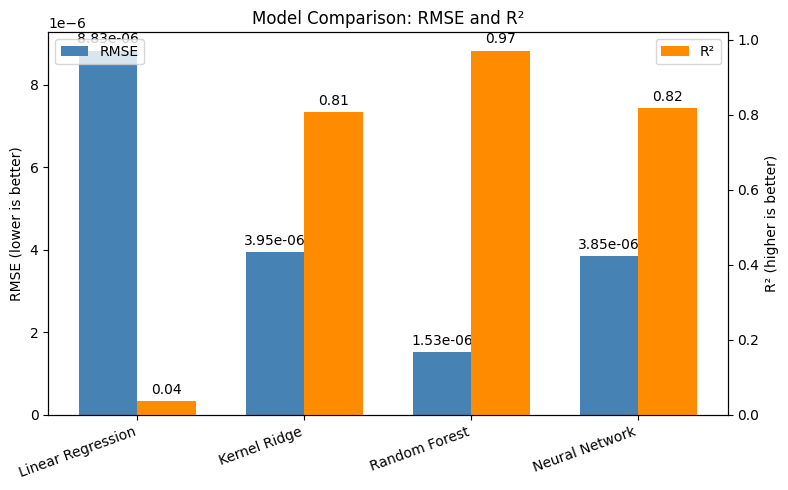

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Models
models = ["Linear Regression", "Kernel Ridge", "Random Forest", "Neural Network"]

# RMSE values (from your results)
rmse = [
    8.831679997842694e-06,  # LR
    3.9520861397931215e-06, # KRR
    1.5328081244567335e-06, # RF
    3.849669397263062e-06   # FCNN
]

# R² values (from your results)
r2 = [
    0.037,  # LR
    0.807,  # KRR
    0.971,  # RF
    0.817   # FCNN
]

# X positions
x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 5))

# Left axis: RMSE
bars1 = ax1.bar(x - width/2, rmse, width, label='RMSE', color='steelblue')
ax1.set_ylabel("RMSE (lower is better)")
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=20, ha="right")

# Right axis: R²
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, r2, width, label='R²', color='darkorange')
ax2.set_ylabel("R² (higher is better)")

# Title
plt.title("Model Comparison: RMSE and R²")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Annotate bars with values
def annotate_bars(bars, ax, fmt="{:.2e}"):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(fmt.format(height),
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Annotate RMSE (scientific notation) and R² (2 decimals)
annotate_bars(bars1, ax1, fmt="{:.2e}")
annotate_bars(bars2, ax2, fmt="{:.2f}")

fig.tight_layout()

# === Save figure ===
plt.savefig("model_comparison.pdf", format="pdf")   # Vector format for LaTeX
plt.savefig("model_comparison.png", dpi=300)        # Optional high-res raster
plt.show()


In [ ]:
# Example results (replace with your actual metrics)
models = ["Linear Regression", "Kernel Ridge", "Random Forest", "Neural Network"]
rmse = [0.35, 0.28, 0.22, 0.15]   # Example RMSE values
r2   = [0.72, 0.80, 0.85, 0.92]   # Example R² values

x = np.arange(len(models))  # Model indices
width = 0.35  # Bar width

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot RMSE (left y-axis)
bars1 = ax1.bar(x - width/2, rmse, width, label='RMSE', color='steelblue')
ax1.set_ylabel("RMSE (lower is better)")
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=20, ha="right")

# Add second y-axis for R²
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, r2, width, label='R²', color='darkorange')
ax2.set_ylabel("R² (higher is better)")

# Title and layout
plt.title("Model Comparison: RMSE and R²")
fig.tight_layout()

# Add legends (one for each axis)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Optional: annotate bars with values
def annotate_bars(bars, ax, fmt="{:.2f}"):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(fmt.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(bars1, ax1)
annotate_bars(bars2, ax2)

plt.show()

In [ ]:

importances = rf.feature_importances_
feature_names = X_val.columns

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.savefig("random_forest_feature_importance.png")
plt.show()


In [ ]:
!pip install shap

In [ ]:
import shap

explainer = shap.Explainer(rf.predict, X)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, feature_names=feature_names)

In [ ]:
# Example test input (one row from your dataset)
test_input = pd.DataFrame({
    "n_el": [768.0],
    "n_el^3": [4.529848e+08],
    "n_species": [2.0],
    "n_at": [168.0],
    "n_transition": [0.0],
    "n_lanthanid": [0.0],
    "n_ks": [461.0],
    "n_g_smooth": [478853.0],
    "n_k": [44.0],
    "n_betas": [102.0],
    "n_cores": [192.0],
    "n_nodes": [6.0],
    "threads_per_node": [4.0],
    "n_pool": [24.0]
})

test_input

In [ ]:
dfx = df_leo.drop(columns = ['n_calls', 'convergence', 'Al1', 'Cl1', 'Co1', 'Cr1', 'F1', 'H1',
       'H2', 'Ir1', 'La1', 'N1', 'Na1', 'Nb1', 'Ni1', 'O1', 'O2', 'Re1', 'S1',
       'Si1', 'Ti1', 'V1'] + elements).astype('float')
dfy = df_leo['normalized_time_per_call'].astype('float')


test_input_0 = dfx.iloc[[10]]  # Keep double brackets to return a DataFrame
#'n_el', 'n_el^3', 'n_species', 'n_at', 'n_transition', 'n_lanthanid',
  #     'n_ks', 'n_g_smooth', 'n_k', 'n_betas', 'n_cores', 'n_nodes',
  #     'threads_per_node', 'n_pool'


#Y_hat =(test_input_0)
print(test_input_0)

In [ ]:
Y_hat = model.predict_normed(test_input)
Y_hat
print(Y_hat[0][0])
print(model.sy)
print(model.my)
print(model.eps)
print(Y_hat[0][0]* model.sy + model.my)

In [ ]:
real_time = model.denormalize_y(Y_hat[0][0])
print(real_time)

# ANN Model for prediction of Number of Calls

In [ ]:
t_hat = Y_hat[:, 0] * X_val['n_el^3']*X_val['n_k']/X_val['n_cores']
t_val = df_leo.loc[ind_val, 'time_per_call']
plt.plot(t_val, t_val, 'k--', lw=.1)
plt.hist2d(t_val, t_hat, bins = np.logspace(0, 2, 151), cmin = 0.01)
# plt.plot(t_val, 2*t_val, 'g-', lw=1)
target = 'Time Per Call [s]'
rmse = np.mean((t_val.values - t_hat)**2)**0.5
r2 = r2_score(t_val, t_hat)
plt.xlabel("True %s" %(target))
plt.ylabel("Predicted %s" %(target))
plt.text(7, 60, "RMSE: %.1f s" %(rmse))
plt.text(7, 80, "R2:     %.2f" %(r2))
plt.xscale('log')
plt.yscale('log')
plt.savefig("ann_prediction_hpc.png")

In [ ]:
dfx_nc = df_leo.drop(columns = ['n_calls', 'Al1', 'Cl1', 'Co1', 'Cr1', 'F1', 'H1',
       'H2', 'Ir1', 'La1', 'N1', 'Na1', 'Nb1', 'Ni1', 'O1', 'O2', 'Re1', 'S1',
       'Si1', 'Ti1', 'V1'] + elements).astype('float')

dfy_nc = df_leo['n_calls'].astype('float')
# dfx.arch = 10
model_nc = ann.TimePerCall(activation='swish', l1=1e-5,
             l2=1e-4, lr=0.00005, loss='mae', nvars = len(dfx_nc.columns))
ind_tr_nc, ind_val_nc = ann.train_test_indices(dfx_nc)
X_tr_nc = dfx_nc.loc[ind_tr_nc]
Y_tr_nc = dfy_nc.loc[ind_tr_nc]
X_val_nc = dfx_nc.loc[ind_val_nc]
Y_val_nc = dfy_nc.loc[ind_val_nc]
model_nc.train_normed(X_tr_nc, Y_tr_nc, epochs=100, validation_split=0.2, plot=1)


In [ ]:
t_hat = Y_hat[:, 0] * X_val['n_el^3']*X_val['n_k']/X_val['n_cores']
t_val = df_leo.loc[ind_val, 'time_per_call']
plt.plot(t_val, t_val, 'k--', lw=.1)
plt.hist2d(t_val, t_hat, bins = np.logspace(0, 2, 151), cmin = 0.01)
# plt.plot(t_val, 2*t_val, 'g-', lw=1)
target = 'Time Per Call [s]'
rmse = np.mean((t_val.values - t_hat)**2)**0.5
r2 = r2_score(t_val, t_hat)
plt.xlabel("True %s" %(target))
plt.ylabel("Predicted %s" %(target))
plt.text(7, 60, "RMSE: %.1f s" %(rmse))
plt.text(7, 80, "R2:     %.2f" %(r2))
plt.xscale('log')
plt.yscale('log')
plt.savefig("ann_prediction_hpc.png")